In [4]:

from inspect import trace
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr

import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as wb
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from tqdm.auto import tqdm
import os


In [5]:
prices = pdr.get_data_yahoo(('AME', 'DOV'))

[*********************100%***********************]  2 of 2 completed


In [6]:
prices = prices[['Adj Close']].dropna()
prices.head()

Adj Close          
                 AME       DOV
Date                          
1984-07-19  0.957632  1.372605
1984-07-20  0.947760  1.377727
1984-07-23  0.923078  1.382849
1984-07-24  0.923078  1.393093
1984-07-25  0.923078  1.413579

In [7]:
import sys
sys.path.append("../")


In [8]:
%load_ext autoreload
%autoreload 2

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
def statsGen(data):
    
    adjClose = data.iloc[:, :2]
    result = coint_johansen(adjClose, det_order=0, k_ar_diff=1)
    
    return result.lr1, result.cvt, result.lr2, result.cvm, result.evec
    

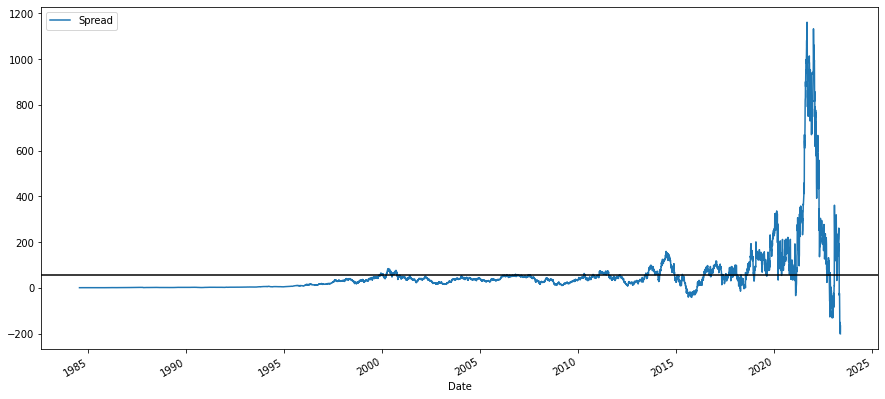

In [11]:
results = coint_johansen(prices, det_order=0, k_ar_diff=1)
results.lr1, results.cvt, results.lr2, results.cvm, results.evec

top_eigenvec = results.evec[:, 0]
# build the portfolio
portfolio = pd.DataFrame()
portfolio['stock_1'] = prices.iloc[:, 0]
portfolio['stock_2'] = prices.iloc[:, 1]
portfolio['hedge_ratio'] = top_eigenvec[0] * portfolio['stock_1'] + top_eigenvec[1] * portfolio['stock_2']
portfolio['spread'] = portfolio['stock_1'] - portfolio['hedge_ratio'] * portfolio['stock_2']
portfolio['spread'].plot(figsize=(15, 7))
plt.axhline(portfolio['spread'].mean(), color='black')
plt.legend(['Spread'])
plt.show()

In [12]:
results.evec

array([[ 0.17795249,  0.00916874],
       [-0.17052634,  0.01762275]])

In [13]:
# cwd = os.getcwd()
# # get rid of the last folder
# cwd = os.path.dirname(cwd)

# stationary = []
# sss = pd.DataFrame(columns=['symb1', 'symb2'])
# path = os.path.join(cwd, 'Cointegrated_Pairs', 'pairs.csv')
# data = pd.read_csv(path)
# for i in range(len(data)):
#     tickers = (data['symb1'][i], data['symb2'][i])

#     prices = wb.DataReader(tickers, data_source='yahoo', interval='1d')['Adj Close']
#     prices = prices.dropna()
#     info = statsGen(prices)
#     lr_stats = info[0][0]
#     lr_90pct_threshold = info[1][0][0]
#     mle_stats = info[2][0]
#     mle_90pct_threshold = info[3][0][0]
    
#     if lr_stats > lr_90pct_threshold and mle_stats > mle_90pct_threshold:
#         stationary.append(tickers)
#         sss = sss.append({'symb1': tickers[0], 'symb2': tickers[1]}, ignore_index=True)
        
# print(len(stationary)/len(data))

In [14]:
tickers = ('AME', 'DOV')

data = wb.DataReader(('AME', 'DOV'), data_source='yahoo', interval='1d')[['Adj Close']]

data = data.dropna()
data

[*********************100%***********************]  2 of 2 completed


Adj Close            
                   AME         DOV
Date                              
1984-07-19    0.957631    1.372605
1984-07-20    0.947760    1.377727
1984-07-23    0.923078    1.382849
1984-07-24    0.923078    1.393092
1984-07-25    0.923078    1.413579
...                ...         ...
2023-05-18  147.789993  140.830002
2023-05-19  147.570007  139.470001
2023-05-22  147.929993  140.199997
2023-05-23  145.970001  139.320007
2023-05-24  144.259995  135.639999

[9792 rows x 2 columns]

In [15]:
data[f'coef_{tickers[0]}'] = None
data[f'coef_{tickers[1]}'] = None
data['portfolio'] = None



In [16]:
# for every entry, use all previous closing prices as input to the cointegration test
# return the results for every week entry
# before market close, eigenvalue and eigenvector are calculated and will be kept for the next week
# since eigenvector changes, high loww should be fouund using combination of high and low of the week


for i in tqdm(range(50, len(data))):

    evec = statsGen(data.iloc[:i+1,:])[4][:, 0]
    coef1 = evec[0]
    coef2 = evec[1]
    data.iloc[i, -3] = coef1
    data.iloc[i, -2] = coef2
    
    if i!=len(data)-1:
        data.iloc[i+1, -1] = coef1 * data.iloc[i, 0] + coef2 * data.iloc[i, 1]

    
        
    
    
    

# print("Eigenvalue: \n", eigenvalue)
# print("Eigenvector: \n", eigenvector)
# print("\n")
# print("Maximum eigenvalue statistic: \n", max_eigen_statistic)
# print("Critical values (90%, 95%, 99%) of maximum eigenvalue statistic. \n", cvm)
# print("\n")
# print("Trace statistic: \n", trace_statistic)
# print("Critical values (90%, 95%, 99%) of trace statistic. \n", cvt)

100%|██████████| 9742/9742 [00:26<00:00, 365.96it/s]


In [17]:
data

Adj Close              coef_AME  coef_DOV portfolio
                   AME         DOV                              
Date                                                            
1984-07-19    0.957631    1.372605      None      None      None
1984-07-20    0.947760    1.377727      None      None      None
1984-07-23    0.923078    1.382849      None      None      None
1984-07-24    0.923078    1.393092      None      None      None
1984-07-25    0.923078    1.413579      None      None      None
...                ...         ...       ...       ...       ...
2023-05-18  147.789993  140.830002  0.178562 -0.169585  2.309567
2023-05-19  147.570007  139.470001  0.178474 -0.169818  2.507082
2023-05-22  147.929993  140.199997  0.178384 -0.169574  2.652894
2023-05-23  145.970001  139.320007  0.178272 -0.169762  2.614073
2023-05-24  144.259995  135.639999  0.177952 -0.170526   2.37113

[9792 rows x 5 columns]

In [18]:
# get rid of all datas before the last None value
adjdata = data.dropna()

In [19]:
# vecm
# Delta y_t = A_1 Delta y_{t-1} + ... + A_p Delta y_{t-p} + B (y_{t-1} - Π y_{t-1}) + e_t


# where:

# y_t is a vector of the original time series at time t
# Delta y_t is the first difference of y_t, which can be used to remove any trend or drift in the series
# A_1, ..., A_p are the short-term dynamics of the model, which capture the dependence of the series on their past values
# B is a matrix of coefficients that represent the long-term relationships among the series, which capture the cointegrating relationships
# Π is a matrix of lagged coefficients that represent the adjustment towards equilibrium
# e_t is a vector of errors or residuals at time t
# In this equation, the matrix B represents the coefficients of the original time series in the linear combinations that form the cointegrating relationships. The columns of B correspond to the eigenvectors obtained from the coint_johansen test.

# For example, suppose you have two time series, X and Y, and you want to determine whether they are cointegrated. You can run the coint_johansen test on the data and obtain the eigenvectors [a, b] and [c, d], which represent the two linear combinations aX + bY and cX + dY.

# You can then use these eigenvectors to construct the VECM for the two series, which would take the form:
    
# Delta [X_t, Y_t] = A_1 Delta [X_{t-1}, Y_{t-1}] + ... + 
# A_p Delta [X_{t-p}, Y_{t-p}] + B ([X_{t-1}, Y_{t-1}] - Π [X_{t-1}, Y_{t-1}]) + e_t
# where:

# X_t and Y_t are the original time series at time t
# B is a matrix with columns [a, b] and [c, d], representing the linear combinations aX + bY and cX + dY

# cointegration不代表要一起动, unless correlation is high, otherwise, moving one can change the portfolio too. 
# 只是给你stationary portfolio, nothing to do with hedging
# based on the coefficients, you can tell which one will generate more effect and trade on that
# trends need to be matched


In [20]:
adjdata['rolling_mean'] = adjdata['portfolio'].expanding().mean()


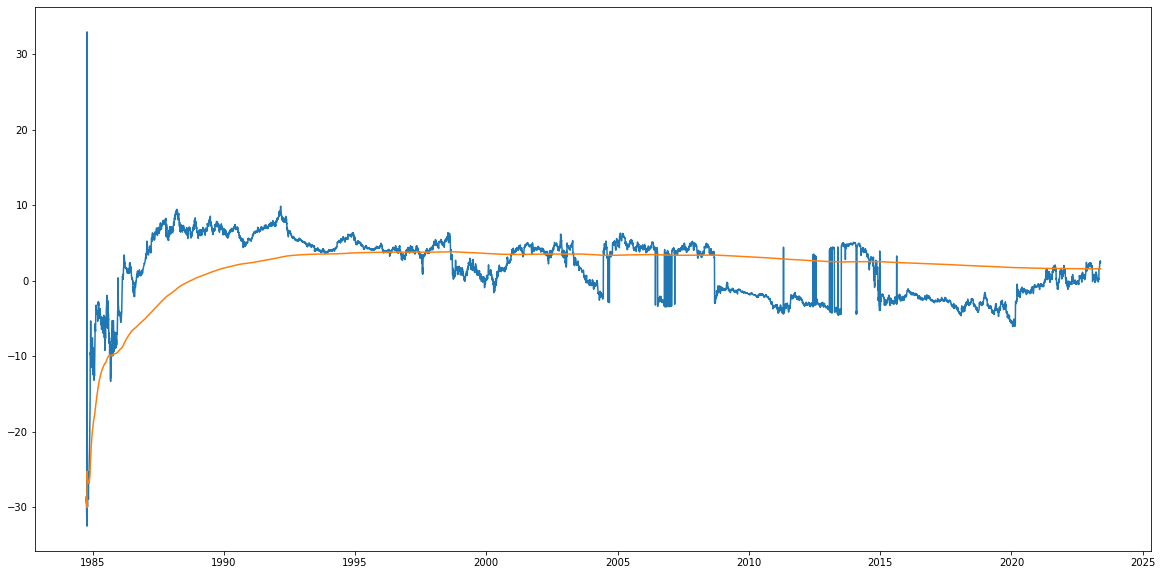

In [21]:
# plot the portfolio
plt.figure(figsize=(20, 10))
plt.plot(adjdata['portfolio'])
plt.plot(adjdata['rolling_mean'])


    


In [22]:
adjdata

Adj Close              coef_AME   coef_DOV  portfolio  \
                   AME         DOV                                   
Date                                                                 
1984-10-01    1.059416    1.488407  2.754389 -21.350253  -28.67872   
1984-10-02    1.059416    1.488407  2.409943 -21.311047 -28.859822   
1984-10-03    1.034547    1.478106  1.779645 -21.126197  -29.16638   
1984-10-04    1.019626    1.483257  3.065061 -21.951614 -29.385635   
1984-10-05    1.024599    1.472955  2.624145 -21.866176 -29.434676   
...                ...         ...       ...        ...        ...   
2023-05-18  147.789993  140.830002  0.178562  -0.169585   2.309567   
2023-05-19  147.570007  139.470001  0.178474  -0.169818   2.507082   
2023-05-22  147.929993  140.199997  0.178384  -0.169574   2.652894   
2023-05-23  145.970001  139.320007  0.178272  -0.169762   2.614073   
2023-05-24  144.259995  135.639999  0.177952  -0.170526    2.37113   

           rolling_mean  
                         
Date                     
1984-10-01   -28.678720  
1984-10-02   -28.769271  
1984-10-03   -28.901640  
1984-10-04   -29.022639  
1984-10-05   -29.105047  
...                 ...  
2023-05-18     1.588875  
2023-05-19     1.588969  
2023-05-22     1.589078  
2023-05-23     1.589183  
2023-05-24     1.589264  

[9741 rows x 6 columns]

In [23]:
# strat 1: simply trade when reach bottom or top 10%

adjdata['entry'] = 0

def entrypoint(data):
    
    # long run expectation, wait for four trading years
    for i in range(1500, len(data)):
        historical = data.iloc[:i, :]
        today_value = data.iloc[i, -3]

        above = historical[historical['portfolio'] >= today_value].shape[0] / historical.shape[0]
        below = historical[historical['portfolio'] <= today_value].shape[0] / historical.shape[0]
        
        if above < 0.025:
            data.iloc[i, -1] = -1
        elif below < 0.025:
            data.iloc[i, -1] = 1
        else:
            data.iloc[i, -1] = 0
            
    return data

adjdata = entrypoint(adjdata)
adjdata

Adj Close              coef_AME   coef_DOV  portfolio  \
                   AME         DOV                                   
Date                                                                 
1984-10-01    1.059416    1.488407  2.754389 -21.350253  -28.67872   
1984-10-02    1.059416    1.488407  2.409943 -21.311047 -28.859822   
1984-10-03    1.034547    1.478106  1.779645 -21.126197  -29.16638   
1984-10-04    1.019626    1.483257  3.065061 -21.951614 -29.385635   
1984-10-05    1.024599    1.472955  2.624145 -21.866176 -29.434676   
...                ...         ...       ...        ...        ...   
2023-05-18  147.789993  140.830002  0.178562  -0.169585   2.309567   
2023-05-19  147.570007  139.470001  0.178474  -0.169818   2.507082   
2023-05-22  147.929993  140.199997  0.178384  -0.169574   2.652894   
2023-05-23  145.970001  139.320007  0.178272  -0.169762   2.614073   
2023-05-24  144.259995  135.639999  0.177952  -0.170526    2.37113   

           rolling_mean entry  
                               
Date                           
1984-10-01   -28.678720     0  
1984-10-02   -28.769271     0  
1984-10-03   -28.901640     0  
1984-10-04   -29.022639     0  
1984-10-05   -29.105047     0  
...                 ...   ...  
2023-05-18     1.588875     0  
2023-05-19     1.588969     0  
2023-05-22     1.589078     0  
2023-05-23     1.589183     0  
2023-05-24     1.589264     0  

[9741 rows x 7 columns]

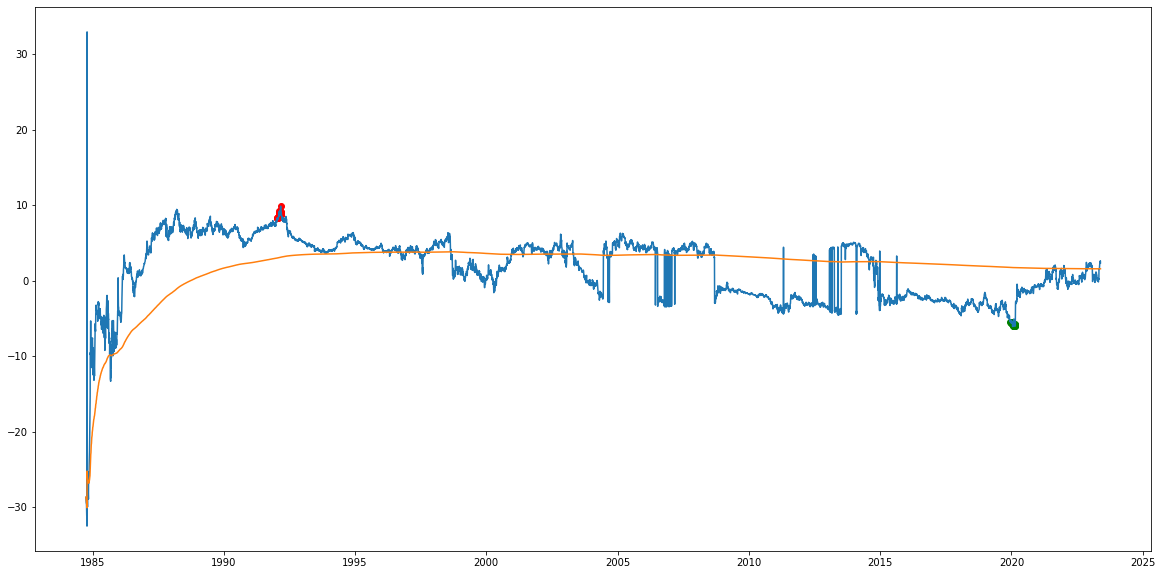

In [24]:
longing = adjdata[adjdata['entry'] == 1].index
shorting = adjdata[adjdata['entry'] == -1].index

# mark this point on the line chart with different color
plt.figure(figsize=(20, 10))
plt.plot(adjdata['portfolio'])
plt.plot(adjdata['rolling_mean'])
plt.scatter(longing, adjdata.loc[longing, 'portfolio'], color='g')
plt.scatter(shorting, adjdata.loc[shorting, 'portfolio'], color='r')


In [25]:
adjdata[adjdata['entry'] == 1]

Adj Close              coef_AME  coef_DOV portfolio rolling_mean  \
                  AME         DOV                                              
Date                                                                           
2019-12-13  96.383293  108.204254  0.137503 -0.171666 -5.421259     1.774478   
2019-12-23  97.928398  110.298851  0.124955 -0.161215  -5.42839     1.769713   
2019-12-24  97.507912  109.737122  0.129123 -0.164592   -5.5452     1.768889   
2019-12-26  97.859947  110.251244  0.125702 -0.161734 -5.471352     1.768074   
2019-12-27  97.742607  109.937050  0.127913 -0.163504 -5.530198     1.767252   
2019-12-30  97.723030  109.718063  0.129278 -0.164571 -5.472603     1.766438   
2020-01-03  98.710724  110.232185  0.125478 -0.161311 -5.620283     1.763987   
2020-01-10  98.534721  110.222664  0.127309  -0.16259 -5.570346     1.759947   
2020-01-14  98.612938  111.507996  0.120076 -0.156499 -5.619708     1.758315   
2020-01-15  98.436913  111.974518  0.116887 -0.153772  -5.60987     1.757487   
2020-01-16  97.977287  113.869148  0.096352 -0.136039 -5.712541     1.756647   
2020-01-17  99.532181  113.802521  0.104328 -0.142939 -6.050339     1.755770   
2020-01-21  99.023674  112.307739  0.116174  -0.15301 -5.882801     1.754911   
2020-01-22  98.055542  112.222046  0.116011 -0.152816  -5.68019     1.754076   
2020-01-23  98.554276  112.964676  0.109749  -0.14744 -5.773789     1.753230   
2020-01-24  97.370987  111.498474  0.122736  -0.15834 -5.839238     1.752377   
2020-01-27  95.620522  109.898972  0.142588 -0.174312 -5.703751     1.751540   
2020-01-31  95.004448  108.394684  0.157951 -0.185732 -6.000126     1.748213   
2020-02-06  96.500656  112.564804  0.117605 -0.153592 -5.946529     1.744995   
2020-02-07  96.129036  111.688873  0.131062 -0.164648 -5.940034     1.744132   
2020-02-10  96.422424  112.555283  0.117776 -0.153615 -5.790506     1.743287   
2020-02-11  97.938187  113.288383  0.113981 -0.150361 -5.933962     1.742426   
2020-02-12  99.522392  114.107162  0.111368  -0.14809 -5.871036     1.741572   
2020-02-13  99.199699  113.831047  0.113654 -0.149982 -5.814529     1.740724   
2020-02-14  99.101913  114.116699  0.110541 -0.147282  -5.79811     1.739879   
2020-02-18  98.251122  114.173805  0.106321 -0.143615 -5.852451     1.739027   
2020-02-19  97.957741  111.631767  0.134183 -0.166775 -5.950852     1.738165   
2020-02-21  97.146065  113.716812    0.1085 -0.145324 -5.782453     1.736514   
2020-02-24  93.253975  109.441963   0.19288 -0.206128  -5.98549     1.735648   

           entry  
                  
Date              
2019-12-13     1  
2019-12-23     1  
2019-12-24     1  
2019-12-26     1  
2019-12-27     1  
2019-12-30     1  
2020-01-03     1  
2020-01-10     1  
2020-01-14     1  
2020-01-15     1  
2020-01-16     1  
2020-01-17     1  
2020-01-21     1  
2020-01-22     1  
2020-01-23     1  
2020-01-24     1  
2020-01-27     1  
2020-01-31     1  
2020-02-06     1  
2020-02-07     1  
2020-02-10     1  
2020-02-11     1  
2020-02-12     1  
2020-02-13     1  
2020-02-14     1  
2020-02-18     1  
2020-02-19     1  
2020-02-21     1  
2020-02-24     1

In [26]:
temp = adjdata.copy()

shift_term = abs(min(temp['portfolio']) - 20)
temp['portfolio'] += shift_term
temp['rolling_mean'] += shift_term

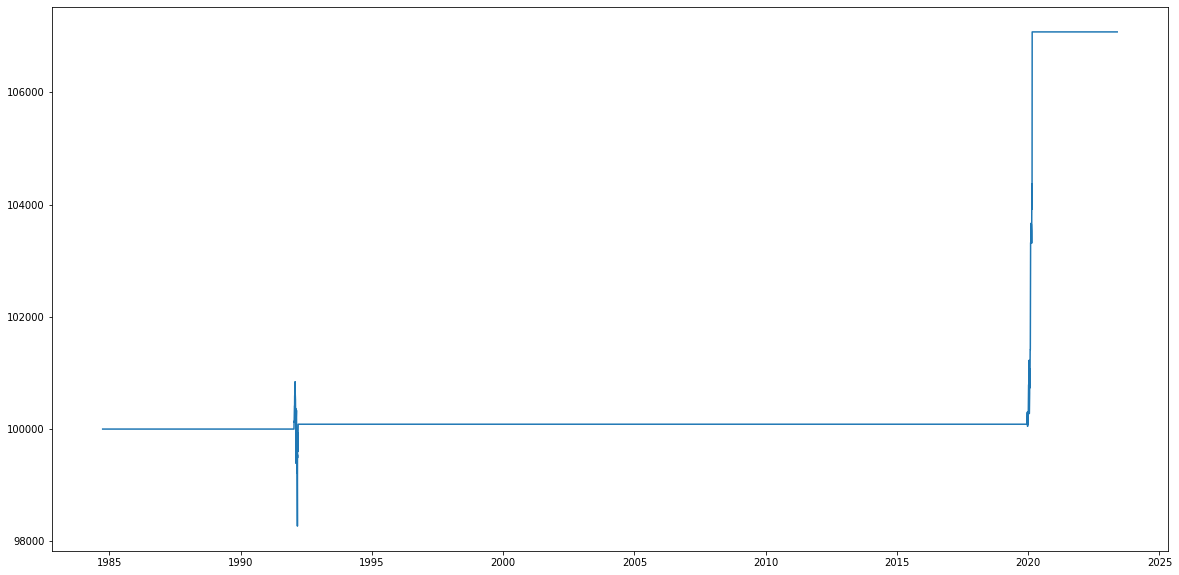

In [27]:
# no shorting backtest

profit = 0
available_capital = 100000
num_shares = 0
floating_portfolios_value = []
dates = temp.index

for i in range(len(temp)):
    
    ## exiting the next day
    available_capital += temp.iloc[i, -3] * num_shares
    num_shares = 0

 
    
    ## opening position
    # longing
    if temp.iloc[i, -1] == 1:
        
        if num_shares == 0:
            
            
            num_shares = available_capital // temp.iloc[i, -3]
            available_capital -= num_shares * temp.iloc[i, -3]
        
            
    # shorting
    elif temp.iloc[i, -1] == -1:
        
        if num_shares == 0:
           
            num_shares = - available_capital // temp.iloc[i, -3]
            available_capital -= num_shares * temp.iloc[i, -3]

        
            
      
    floating_portfolios_value.append(available_capital + num_shares * temp.iloc[i, -3])
    
# plot the floating value
plt.figure(figsize=(20, 10))
plt.plot(dates, floating_portfolios_value)



In [28]:
port_return = (floating_portfolios_value[-1] - 100000) / 100000
port_return

0.07074733103027073